In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df = pd.read_csv('/content/creditcard.csv')

# missing values
print("missing values:", df.isnull().values.any())

missing values: True


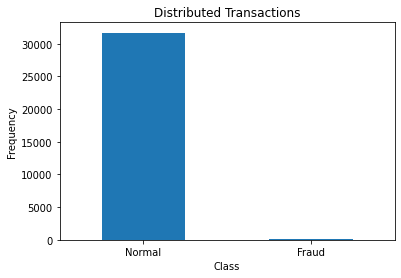

In [5]:
# plot normal and fraud
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Distributed Transactions")
plt.xticks(range(2), ['Normal', 'Fraud'])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

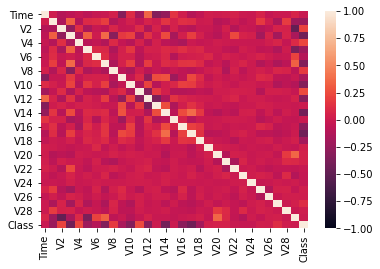

In [6]:
sns.heatmap(df.corr(), vmin=-1)
plt.show()

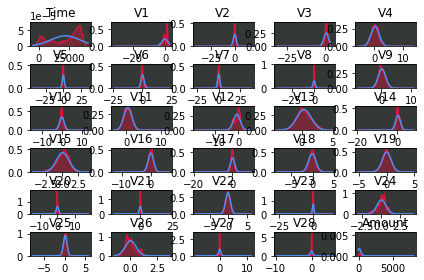

In [7]:
fig, axs = plt.subplots(6, 5, squeeze=False)
for i, ax in enumerate(axs.flatten()):
   ax.set_facecolor('xkcd:charcoal')
   ax.set_title(df.columns[i])
   sns.distplot(df.iloc[:, i], ax=ax, fit=norm,
               color="#DC143C", fit_kws={"color": "#4e8ef5"})
   ax.set_xlabel('')
fig.tight_layout(h_pad=-1.5, w_pad=-1.5)
plt.show()

In [8]:
classes = df['Class']
df.drop(['Time', 'Class', 'Amount'], axis=1, inplace=True)
cols = df.columns.difference(['Class'])
MMscaller = MinMaxScaler()
df = MMscaller.fit_transform(df)
df = pd.DataFrame(data=df, columns=cols)
df = pd.concat([df, classes], axis=1)

In [9]:
import pandas as pd
import numpy as np

def train_validation_splits(df):

   # Fraud Transactions
   fraud = df[df['Class'] == 1]
   # Normal Transactions
   normal = df[df['Class'] == 0]
   print('normal:', normal.shape[0])
   print('fraud:', fraud.shape[0])

   normal_test_start = int(normal.shape[0] * .2)
   fraud_test_start = int(fraud.shape[0] * .5)
   normal_train_start = normal_test_start * 2

   val_normal = normal[:normal_test_start]
   val_fraud = fraud[:fraud_test_start]
   validation_set = pd.concat([val_normal, val_fraud], axis=0)

   test_normal = normal[normal_test_start:normal_train_start]
   test_fraud = fraud[fraud_test_start:fraud.shape[0]]
   test_set = pd.concat([test_normal, test_fraud], axis=0)

   Xval = validation_set.iloc[:, :-1]
   Yval = validation_set.iloc[:, -1]

   Xtest = test_set.iloc[:, :-1]
   Ytest = test_set.iloc[:, -1]

   train_set = normal[normal_train_start:normal.shape[0]]
   Xtrain = train_set.iloc[:, :-1]

   return Xtrain.to_numpy(), Xtest.to_numpy(), Xval.to_numpy(), Ytest.to_numpy(), Yval.to_numpy()

In [10]:
def estimate_gaussian_params(X):
   """
   Calculates the mean and the covariance for each feature.

   Arguments:
   X: dataset
   """
   mu = np.mean(X, axis=0)
   sigma = np.cov(X.T)
   
   return mu, sigma

In [11]:
(Xtrain, Xtest, Xval, Ytest, Yval) = train_validation_splits(df)

(mu, sigma) = estimate_gaussian_params(Xtrain)

# calculate gaussian pdf
p = multivariate_normal.pdf(Xtrain, mu, sigma)
pval = multivariate_normal.pdf(Xval, mu, sigma)
ptest = multivariate_normal.pdf(Xtest, mu, sigma)

normal: 31677
fraud: 102


In [12]:
def metrics(y, predictions):
   fp = np.sum(np.all([predictions == 1, y == 0], axis=0))
   tp = np.sum(np.all([predictions == 1, y == 1], axis=0))
   fn = np.sum(np.all([predictions == 0, y == 1], axis=0))

   precision = (tp / (tp + fp)) if (tp + fp) > 0 else 0
   recall = (tp / (tp + fn)) if (tp + fn) > 0 else 0
   F1 = (2 * precision * recall) / (precision +
                                    recall) if (precision + recall) > 0 else 0
   return precision, recall, F1
   
def selectThreshold(yval, pval):
   e_values = pval
   bestF1 = 0
   bestEpsilon = 0

   for epsilon in e_values:
       predictions = pval < epsilon

       (precision, recall, F1) = metrics(yval, predictions)

       if F1 > bestF1:
           bestF1 = F1
           bestEpsilon = epsilon

   return bestEpsilon, bestF1

In [13]:
(epsilon, F1) = selectThreshold(Yval, pval)

print("Best epsilon found:", epsilon)
print("Best F1 on cross validation set:", F1)

(test_precision, test_recall, test_F1) = metrics(Ytest, ptest < epsilon)
print("Outliers found:", np.sum(ptest < epsilon))
print("Test set Precision:", test_precision)
print("Test set Recall:", test_recall)
print("Test set F1 score:", test_F1)


Best epsilon found: 1.4077209285028484e-35
Best F1 on cross validation set: 0.6451612903225806
Outliers found: 88
Test set Precision: 0.42045454545454547
Test set Recall: 0.7254901960784313
Test set F1 score: 0.5323741007194245
